**Main imports**

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
from torch.nn.utils import spectral_norm    
from torch import optim;
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device.type)

cuda


**Import dataset**

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize([32,32]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')
print("Number of classes: ", len(class_names))

batch_size = 64

num_batches_per_epoch = len(train_loader.dataset) // batch_size

num_of_epochs = 50000 // num_batches_per_epoch

print("Number of batches per epoch: ", num_batches_per_epoch)
print("Number of epochs: ", num_of_epochs)

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000
Number of classes:  100
Number of batches per epoch:  781
Number of epochs:  64


**View some of the test dataset**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


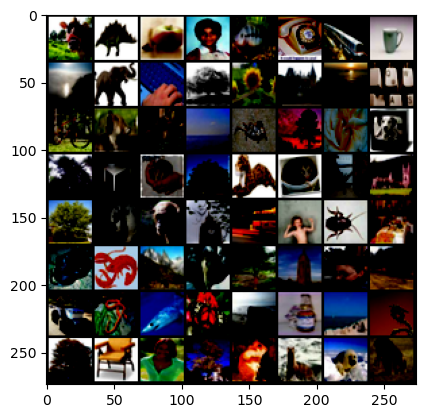

In [3]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x, t = next(train_iterator)

# Ensure the tensor is correctly moved to the GPU
x = x.to(device)
t = t.to(device)

# Plot the images
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0))
plt.show()

### Generator, Discriminator, and Training Loop

In [4]:
# hyperparameters
batch_size = train_loader.batch_size
# channels = 3
# latent_dim = 256
# image_size = 32

num_classes = 100

check_interval = 5

num_of_epochs = 50000

Repo: https://github.com/atapour/dl-pytorch/blob/main/Conditional_GAN_Example/Conditional_GAN_Example.ipynb

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from scipy import linalg
from torchvision.models.inception import inception_v3
from torchvision.utils import make_grid

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        
        # FC layers for mean and variance
        self.fc_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_var = nn.Linear(256 * 2 * 2, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256 * 2 * 2)  # Adjusted feature map size

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 256, 2, 2)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = torch.sigmoid(self.deconv4(x))  # Normalized output
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

def calculate_fid(real_features, fake_features):
    # Calculate mean and covariance statistics
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    
    # Calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def get_inception_features(images, inception_model):
    features = []
    inception_model.eval()
    with torch.no_grad():
        for batch in images:
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            feat = inception_model(batch)[0].squeeze()
            features.append(feat.cpu().numpy())
    return np.concatenate(features)

def display_generated_images(vae, device, epoch):
    """
    Generates and displays a grid of 9 images with their predicted labels.
    """
    vae.eval()
    with torch.no_grad():
        # Generate 9 random latent vectors
        z = torch.randn(9, vae.decoder.fc.in_features).to(device)
        
        # Generate images
        generated_images = vae.decoder(z)
        
        # Denormalize images for display
        generated_images = generated_images * 0.5 + 0.5
        
        # Create a grid of images
        img_grid = make_grid(generated_images, nrow=3, padding=2, normalize=False)
        
        # Convert to numpy for matplotlib
        img_grid = img_grid.cpu().numpy().transpose((1, 2, 0))
        
        # Create figure with subplots
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))
        
        # Plot each image with its predicted label
        for idx in range(9):
            row = idx // 3
            col = idx % 3
            
            # Get individual image
            img = generated_images[idx].cpu().numpy().transpose((1, 2, 0))
            
            # Display image
            axs[row, col].imshow(img)
            
            # Generate a random label for demonstration
            # In a real scenario, you might want to use a classifier to predict the label
            random_label = class_names[np.random.randint(len(class_names))]
            axs[row, col].set_title(f'Generated: {random_label}')
            axs[row, col].axis('off')
        
        save_dir = os.path.join('generated_images', f'epoch_{epoch+1}')
        plt.suptitle(f'Generated Images - Epoch {epoch+1}')
        # plt.savefig(f'generated_images_epoch_{epoch+1}.png')
        plt.savefig(f'{save_dir}.png')
        plt.show()
        plt.close()

def train_vae(latent_dim=64):

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Data loaders with normalization
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100('data', train=True, download=True, 
            transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])),
        batch_size=64, drop_last=True)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100('data', train=False, download=True,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.Resize([32,32]),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])),
        batch_size=64, drop_last=True)

    # Create cyclic iterators
    train_iterator = iter(cycle(train_loader))
    test_iterator = iter(cycle(test_loader))

    # Calculate training parameters
    batch_size = 64
    num_batches_per_epoch = len(train_loader.dataset) // batch_size
    num_epochs = 50000 // num_batches_per_epoch

    print(f'> Size of training dataset: {len(train_loader.dataset)}')
    print(f'> Size of test dataset: {len(test_loader.dataset)}')
    print(f'> Number of classes: {len(class_names)}')
    print(f'> Number of batches per epoch: {num_batches_per_epoch}')
    print(f'> Number of epochs: {num_epochs}')

    # Initialize VAE and optimizer
    vae = VAE(latent_dim).to(device)
    optimizer = optim.AdamW(vae.parameters(), lr=0.0002, weight_decay=1e-5)
    
    # Initialize Inception model for FID score
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.fc = nn.Identity()

    print(f'Generator has {len(torch.nn.utils.parameters_to_vector(vae.parameters()))} parameters.')
    
    # Training loop
    total_steps = num_epochs * num_batches_per_epoch
    step = 0
    
    while step < total_steps:
        vae.train()
        epoch = step // num_batches_per_epoch
        epoch_loss = 0
        
        for batch_idx in range(num_batches_per_epoch):
            data, labels = next(train_iterator)
            assert data.size(0) == batch_size, f"Batch size mismatch: {data.size(0)} != {batch_size}"
            assert labels.size(0) == batch_size, f"Batch size mismatch: {labels.size(0)} != {batch_size}"
            assert data.is_cuda, "Data is not on CUDA"
            assert labels.is_cuda, "Labels are not on CUDA"
            data = data.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, log_var = vae(data)
            
            # Reconstruction loss (using MSE for normalized images)
            recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
            
            # KL divergence loss
            kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Total loss with beta-VAE formulation
            # beta = 1.0  # Adjust this value to control disentanglement
            beta = min(1.0, epoch / 10)
            loss = recon_loss + beta * kld_loss
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            step += 1
            
            # Print progress
            if batch_idx % 100 == 0:
                print(f'Step [{step}/{total_steps}], Loss: {loss.item()/len(data):.4f}')
        
        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / (num_batches_per_epoch * batch_size)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

        display_generated_images(vae, device, epoch)
    return vae

model = train_vae(latent_dim=100)

print(f'Generator has {len(torch.nn.utils.parameters_to_vector(model.parameters()))} parameters.')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset: 50000
> Size of test dataset: 10000
> Number of classes: 100
> Number of batches per epoch: 781
> Number of epochs: 64


c:\Users\Billy\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Billy\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generator has 1688907 parameters.


AssertionError: Data is not on CUDA

**Latent interpolations**

In [ ]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(batch_size))

z0 = z[0:col_size].repeat(col_size,1) # z for top row
z1 = z[batch_size-col_size:].repeat(col_size,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = Generator.sample(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [7]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [9]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory} # remove any existing (old) data
    os.makedirs(directory)

# setup_directory(real_images_dir)
# setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(batch_size, latent_dim).to(device)
    samples_batch = N.sample(z).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [ ]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")